## DEM Data Pre-Processing, Feature Extractions and Descriptive Statistics

#### Datasets Used:
    - Digital Elevation Model (DEM):
        DEM is a digital model or 3D representation of a terrain's surface, created from terrain elevation data. 
    - ESRI Shape Files:
        The shapefile format is a popular geospatial vector data format for GIS software. 
        It is developed and regulated by Esri as a (mostly) open specification for data interoperability.
            
#### Data Sources
For this project we have used DEM available at Bhuvan (http://bhuvan.nrsc.gov.in), which is the Geoportal of Indian Space Research Organisation (ISRO) and provides various remote sensing datasets for India. Bhuvan Open Data Archive provides CartoDEM, a national digital elevation model generated from Cartosat-1 stereo data. Cartosat-1 is capable of  delivering high-resolution satellite data of 2.5 m in-track stereo. CartoDEM is generated using Augmented Stereo Strip Triangulation (ASST) - indigenously developed software by Space Application Centre, ISRO. The seamless CartoDEM generation is an automatic process and makes use of limited Ground Control Points (GCPs) in long stereo strip pairs using dense feature matching, Triangulated Irregular Network (TIN) modeling and automatic long strip mosaicing. CartoDEM vertical accuracy is about 8m at 90% confidence. The generated DEM and ortho images of each Cartosat-1 segment are cut into tiles of 7.5’x7.5’ extents. The entire Indian region is covered by approximately 500 Cartosat-1 segments with a total number of around 20,000 tile pairs. More than 80% of India is covered by CartoDEM and work is in progress to complete remaining parts of the country. CartoDEM v3 which is used in this project, also provides waterbody information as a shape file.

For Bengaluru data, the following tiles are downloaded
Tile ID: D43X (77E12N - 78E13N) and D43R (77E13N - 78E14N)

State & District Boundaries in Shape File format: http://projects.datameet.org/maps/
Parliamentary Constituencies Maps are provided by Data{Meet} Community Maps Project. Its made available under the Creative Commons Attribution 2.5 India.
Assembly Constituencies Maps are provided by Data{Meet} Community Maps Project. Its made available under the Creative Commons Attribution 2.5 India.

Bangalore Ward Maps 2012 in Shape File format: http://openbangalore.org/available-data/#gis_maps
The chosen license is ODbL. It’s similar to Creative Commons, Share Alike and Attribute License. It’s used to keep the modifications or additions to data open as well.

#### Important Libraries

GDAL - Geospatial Data Abstraction Library (http://gdal.org/):
GDAL is a translator library for raster and vector geospatial data formats that is released under an X/MIT style Open Source license by the Open Source Geospatial Foundation. As a library, it presents a single raster abstract data model and single vector abstract data model to the calling application for all supported formats. It also comes with a variety of useful command line utilities for data translation and processing. The GDAL/OGR Python bindings has been used extensively for reading & processing digital elevation model (DEM) rasters.

PyDEM (https://github.com/creare-com/pydem):
PyDEM is a package for topographic (terrain) analysis written in Python (with a bit of Cython). It takes in digital elevation model (DEM) rasters, and it outputs quantities like slope, aspect, upstream area, and topographic wetness index.

In [1]:
import gdal
from gdalconst import * 

import numpy as np
from numpy import linspace
from numpy import meshgrid
from numpy import gradient
from numpy import pi
from numpy import arctan
from numpy import arctan2
from numpy import sin
from numpy import cos
from numpy import sqrt
from numpy import zeros
from numpy import uint8
from numpy import logical_and
from numpy import maximum
from numpy import minimum
from numpy import equal
from numpy import ones
from numpy import choose
from numpy import mod
from numpy import asarray

from mpl_toolkits.basemap import Basemap
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors

import pandas as pd
import collections
#import elevation
from pydem.dem_processing import DEMProcessor

from linecache import getline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import seaborn as sn

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)

In [2]:
# Read raster files and 
def readRaster(filename, bandnum=1):
    """
    Uses a gdal to read DEM
    Returns elevation as an array and geoTransform
    """
    
    # Use gdal to read the DEM file
    dataset = gdal.Open(filename, GA_ReadOnly)
    
    # For the DEM in use there is only one Raster band which needs to be read
    band = dataset.GetRasterBand(bandnum)
    
    # Read the nodata values
    nodata = band.GetNoDataValue()

    #Read the elevation values as a numpy array
    elevation = band.ReadAsArray(0, 0, dataset.RasterXSize, dataset.RasterYSize).astype(np.int16)

    # Mask numpy array to remove nodata sections
    if nodata is not None:
        elevation = np.ma.masked_equal(elevation, nodata)
    
    # Get Geo transform which consists of
    # Origin x coordinate
    # Pixel width
    # x pixel rotation (0° if image is north up)
    # Origin y coordinate
    # y pixel rotation (0° if image is north up)
    # Pixel height (negative)
    geotransform = dataset.GetGeoTransform()
  
    return (dataset, elevation, geotransform)

In [3]:
def calculateXY(elevation, geotransform):
    
    # Calculate the various x,y points in the image
    xres = geotransform[1]
    yres = geotransform[5]

    xmin = geotransform[0] + xres * 0.5
    xmax = geotransform[0] + (xres * elevation.shape[1]) - xres * 0.5
    ymin = geotransform[3] + (yres * elevation.shape[0]) + yres * 0.5
    ymax = geotransform[3] - yres * 0.5

    x_center=(xmin+xmax)/2
    y_center=(ymin+ymax)/2 
    
    return (xres, yres, xmin, ymin, xmax, ymax, x_center, y_center)

In [4]:
def tmercPlot(elevation, geotransform, overridemethod=None, cmName=None):
    
    xres, yres, xmin, ymin, xmax, ymax, x_center, y_center = calculateXY(elevation, geotransform)
    
    data = np.flipud(elevation) # since the plotting happens row-wise from bottom to top, the array needs to be flipped 

    # llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
    # are the lat/lon values of the lower left and upper right corners
    # of the map.
    # resolution = 'i' means use intermediate resolution coastlines.
    # lon_0, lat_0 are the central longitude and latitude of the projection.

    m = Basemap(llcrnrlon=xmin,llcrnrlat=ymin,urcrnrlon=xmax,urcrnrlat=ymax,
                 resolution='i', projection='tmerc', lat_0 = y_center, lon_0 = x_center)

    parallels = np.arange(ymin - 2,ymax + 2,0.25)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=12, linewidth=0.4) 

    meridians = np.arange(xmin-2,xmax+2,0.25)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=12, linewidth=0.4)

    x = linspace(0, m.urcrnrx, data.shape[1])
    y = linspace(0, m.urcrnry, data.shape[0])

    xx, yy = meshgrid(x, y)

    if overridemethod is None:
        if cmName is None:
            cmName =plt.cm.jet
        m.pcolormesh(xx, yy, data, cmap=cmName)
    else:
        if cmName is None:
            cmName =plt.cm.viridis
        m.contourf(xx,yy,data,cmap=cmName)
   
    return m 



In [5]:
def latlon2Pixel(geoMatrix, x, y):
  """
  Uses a gdal geomatrix (gdal.GetGeoTransform()) to calculate
  the pixel location of a geospatial coordinate 
  """
  ulX = geoMatrix[0] #lat
  ulY = geoMatrix[3] #lon
  xDist = geoMatrix[1] #size x
  yDist = geoMatrix[5] #size y
  rtnX = geoMatrix[2] #rotation x
  rtnY = geoMatrix[4] #rotation y
  pixel = int((x - ulX) / xDist)
  line = int((ulY - y) / yDist)
  return (abs(pixel), abs(line))

In [6]:
def demStats(elevation, bins = 100, range=None):
    stats = collections.OrderedDict()

    stats = {'C01: MEAN': np.nanmean(elevation),
             'C02: MEDIAN': np.ma.median(elevation), #np.nanmedian(elevation)
             'C03: STD DEV': np.nanstd(elevation),
             'C04: MIN': np.nanmin(elevation),
             'C05: MAX': np.nanmax(elevation),
             'C06: 1%': np.nanpercentile(elevation, 1),
             'C07: 5%': np.nanpercentile(elevation, 5),
             'C08: 10%': np.nanpercentile(elevation, 10),
             'C09: 25%': np.nanpercentile(elevation, 25),
             'C10: 50%': np.nanpercentile(elevation, 50),
             'C11: 75%': np.nanpercentile(elevation, 75),
             'C12: 90%': np.nanpercentile(elevation, 90),
             'C13: 95%': np.nanpercentile(elevation, 95),
             'C14: 99%': np.nanpercentile(elevation, 99),          
             'C15: SIZE': np.size(elevation)}

    dfStats = pd.DataFrame(stats, index=[0])
    
    hist, bin_edges = np.histogram(elevation, bins, range)

    plt.figure(figsize=(7.5, 4))
    
    width = 0.7 * (bin_edges[1] - bin_edges[0])
    center = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    #plt.show()
    #plt.bar(bin_edges[:-1], hist, width = 1)
    plt.xlim(min(bin_edges), max(bin_edges))
    plt.xlabel('Elevation')
    plt.ylabel('Frequency')
    plt.title('Histogram of Elevations in DEM')
    plt.grid(True)
    plt.show() 
    
    return dfStats

In [7]:
def ClipDEMTileBySubRaster(mainRaster, subRaster, showPlot=False, shpfilePath=None,shpfileName=None) :
    
    # Get boundary co-ordinates of sub raster
    subDataset = gdal.Open(subRaster, GA_ReadOnly)
    subGeotransform = subDataset.GetGeoTransform()
    subBand = subDataset.GetRasterBand(1)
    subElevation = subBand.ReadAsArray(0, 0, subDataset.RasterXSize, subDataset.RasterYSize).astype(np.int16)
    xres, yres, xmin, ymin, xmax, ymax, x_center, y_center = calculateXY(subElevation, subGeotransform)
    
    # Now get the raster array from the main raster
    dataset = gdal.Open(mainRaster, GA_ReadOnly)
    geotransform = dataset.GetGeoTransform()
    band = dataset.GetRasterBand(1)
    elevation = band.ReadAsArray(0, 0, dataset.RasterXSize, dataset.RasterYSize).astype(np.int16)
    
    # Get the 4 corner point pixels in the main raster based on the sub rasters lat n lon
    ulX, ulY = latlon2Pixel(geotransform, xmin, ymin)
    lrX, lrY = latlon2Pixel(geotransform, xmax, ymax)
    
    # Now clip the main raster by the corner points
    clip = elevation[lrY:ulY, ulX:lrX]
    
    if(showPlot):
        data = np.flipud(clip) # since the plotting happens row-wise from bottom to top, the array needs to be flipped 

        # plot the raster dataset
        fig = plt.figure(figsize=(15, 8))
        ax = fig.add_subplot(111, facecolor='w', frame_on=True)

        # llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
        # are the lat/lon values of the lower left and upper right corners
        # of the map.
        # resolution = 'i' means use intermediate resolution coastlines.
        # lon_0, lat_0 are the central longitude and latitude of the projection.

        m = Basemap(llcrnrlon=xmin,llcrnrlat=ymin,urcrnrlon=xmax,urcrnrlat=ymax,
                     resolution='i', projection='tmerc', lat_0 = y_center, lon_0 = x_center)

        parallels = np.arange(ymin - 2,ymax + 2,0.25)
        m.drawparallels(parallels,labels=[1,0,0,0],fontsize=12, linewidth=0.4) 

        meridians = np.arange(xmin-2,xmax+2,0.25)
        m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=12, linewidth=0.4)

        x = linspace(0, m.urcrnrx, data.shape[1])
        y = linspace(0, m.urcrnry, data.shape[0])

        xx, yy = meshgrid(x, y)

        m.contourf(xx,yy,data,cmap=plt.cm.viridis)

        m.readshapefile(shpfilePath+'/'+shpfileName, shpfileName, drawbounds = True, color='red')

        cbar = plt.colorbar()

        plt.show()
    
    # Return the clipped raster
    return clip, geotransform

### Read digital elevation model (DEM) rasters and plot with Transverse Mercator Projection

/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


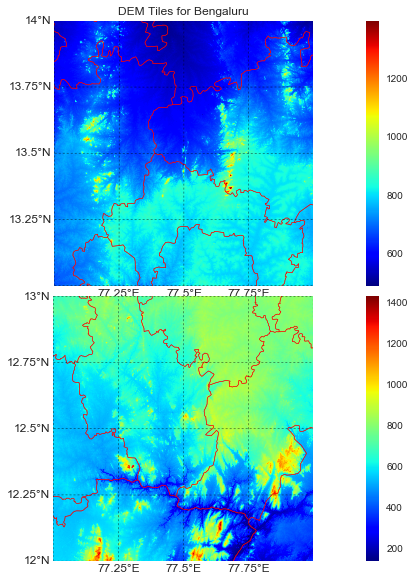

In [8]:
# set raster paths
raster1 = "./images/bhuvan/cdnd43r_v3r1/cdnd43r.tif"
raster2 = "./images/bhuvan/cdnd43x_v3r1/cdnd43x.tif"
shpfilePath = "./images/maps-master/Districts/Census_2011"
shpfileName = "2011_Dist"
plotTitle = "DEM Tiles for Bengaluru"

# read the raster datasets
dataset1, elevation1, geotransform1 = readRaster(raster1)
dataset2, elevation2, geotransform2 = readRaster(raster2)

# plot the raster dataset
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(211)
ax.set_title(plotTitle)
m1 = tmercPlot(elevation1, geotransform1)
m1.readshapefile(shpfilePath+'/'+shpfileName, shpfileName, drawbounds = True, color='red')
cbar1 = plt.colorbar()

ax = fig.add_subplot(212)
m2 = tmercPlot(elevation2, geotransform2)
m2.readshapefile(shpfilePath+'/'+shpfileName, shpfileName, drawbounds = True, color='red')
cbar2 = plt.colorbar()

plt.tight_layout()
plt.show()

### Distribution of elevations & histogram

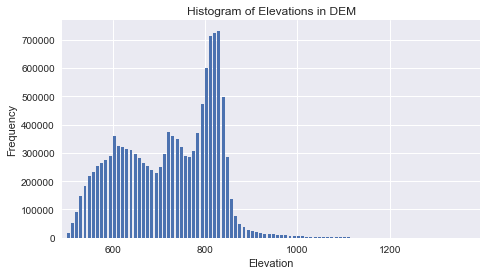

C01: MEAN  C02: MEDIAN  C03: STD DEV  C04: MIN  C05: MAX  C06: 1%  \
0  720.523301        734.0     102.79334       489      1397    523.0   

   C07: 5%  C08: 10%  C09: 25%  C10: 50%  C11: 75%  C12: 90%  C13: 95%  \
0    550.0     574.0     632.0     734.0     809.0     835.0     848.0   

   C14: 99%  C15: SIZE  
0     927.0   12960000

In [9]:
demStats(elevation1)

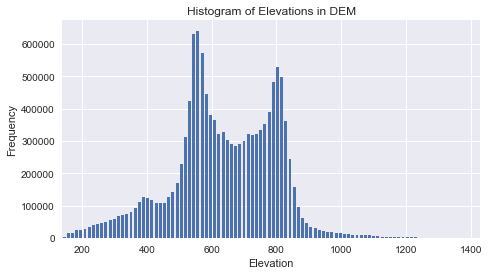

C01: MEAN  C02: MEDIAN  C03: STD DEV  C04: MIN  C05: MAX  C06: 1%  C07: 5%  \
0  636.35229        633.0    159.182962       138      1430    224.0    346.0   

   C08: 10%  C09: 25%  C10: 50%  C11: 75%  C12: 90%  C13: 95%  C14: 99%  \
0     423.0     543.0     633.0     768.0     821.0     848.0     980.0   

   C15: SIZE  
0   12960000

In [10]:
demStats(elevation2)

## Mosaic 2 tiles and generate 1 raster

This is done using GDAL command line utility

gdal_merge.py -n 0 -a_nodata 0 -of GTiff -o <...>/images/output/cdnd43rx.tif <...>/images/bhuvan/cdnd43r_v3r1/cdnd43r.tif <...>/images/bhuvan/cdnd43x_v3r1/cdnd43x.tif


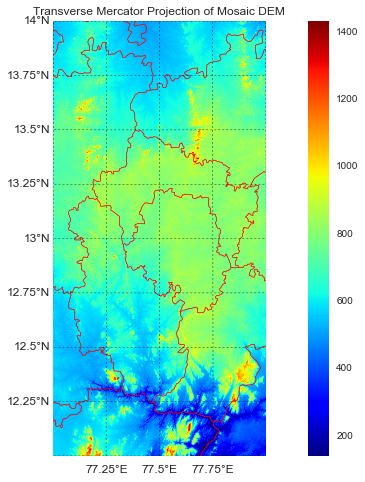

In [11]:
# set raster paths
rastercom = "./images/output/cdnd43rx.tif"
shpfilePath = "./images/maps-master/Districts/Census_2011"
shpfileName = "2011_Dist"
plotTitle = "Transverse Mercator Projection of Mosaic DEM"

# read the raster datasets
datasetcom, elevationcom, geotransformcom = readRaster(rastercom)

# plot the raster dataset
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, facecolor='w', frame_on=True)
m = tmercPlot(elevationcom, geotransformcom)
m.readshapefile(shpfilePath+'/'+shpfileName, shpfileName, drawbounds = True, color='red')

plt.title(plotTitle)
cbar = plt.colorbar()

plt.show()

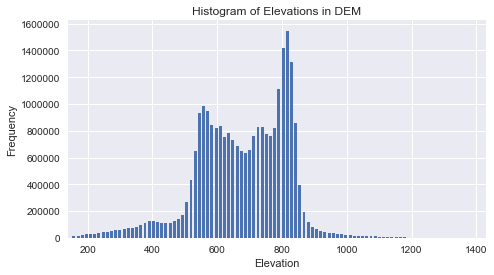

C01: MEAN  C02: MEDIAN  C03: STD DEV  C04: MIN  C05: MAX  C06: 1%  \
0  678.437795        693.0    140.442276       138      1430    265.0   

   C07: 5%  C08: 10%  C09: 25%  C10: 50%  C11: 75%  C12: 90%  C13: 95%  \
0    423.0     521.0     581.0     693.0     796.0     830.0     848.0   

   C14: 99%  C15: SIZE  
0     952.0   25920000

In [12]:
demStats(elevationcom)

## Clipping raster based on Bengaluru district shapefile

This is done using 

gdalwarp -dstnodata 0 -q -cutline <...>/images/bengaluru_shp/bengaluru_district.shp -crop_to_cutline -tr 0.000277777777778 0.000277777777778 -of GTiff <...>/images/output/cdnd43rx.tif <...>/images/output/bengaluru_cropped.tif

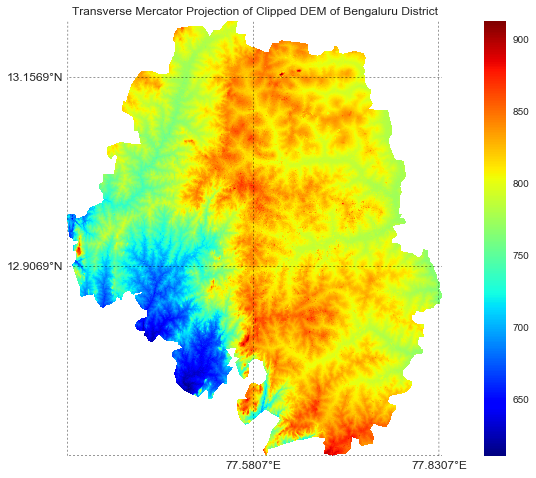

In [13]:
# set raster paths
raster = "./images/output/bengaluru_cropped.tif"
#shpfilePath = "./images/maps-master/Districts/Census_2011"
#shpfileName = "2011_Dist"
plotTitle = "Transverse Mercator Projection of Clipped DEM of Bengaluru District"

# read the raster datasets
dataset, elevation, geotransform = readRaster(raster)

# plot the raster dataset
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, facecolor='w', frame_on=True)
m = tmercPlot(elevation, geotransform)
#m.readshapefile(shpfilePath+'/'+shpfileName, shpfileName, drawbounds = True, color='red')

plt.title(plotTitle)
cbar = plt.colorbar()

plt.show()

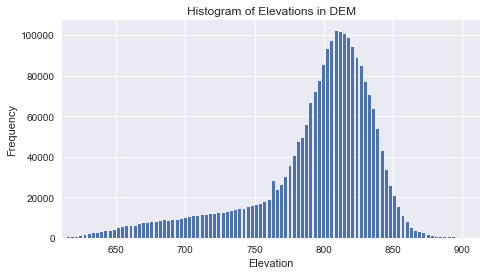

C01: MEAN  C02: MEDIAN  C03: STD DEV  C04: MIN  C05: MAX  C06: 1%  \
0  793.562082        805.0      45.37683       611       913    650.0   

   C07: 5%  C08: 10%  C09: 25%  C10: 50%  C11: 75%  C12: 90%  C13: 95%  \
0    691.0     724.0     779.0     805.0     823.0     837.0     845.0   

   C14: 99%  C15: SIZE  
0     859.0    2356522

In [14]:
#Remove nodata regions outside of Bengaluru boundary introduced in clipping 
elevationnonmask = elevation.compressed()
demStats(elevationnonmask)

## Compute slope and aspect of an area using DEM data

Slope and aspect are calculated at each point in the raster grid, by comparing the point’s elevation to that of its neighbours (usually 8 neigbours but implementations vary). We have used the Python package pyDEM which uses 8 neighbours.  The slope (meters / meters) gives the change in elevation over the change in horizontal distance, quantifying the steepness of the topography. The aspect gives the angle (in radians) at each element. The aspect is important for determining the direction that water will flow, and is also important for solar radiation (for example, a north-facing slope is more shaded than a south-facing slope in the northern hemisphere). 

Reference paper on pyDEM and Slope & Aspect calculations in pyDEM:
pyDEM: Global Digital Elevation Model Analysis: Mattheus P. Ueckermann, Robert D. Chambers, Christopher A. Brooks, William E. Audette III, Jerry Bieszczad
https://conference.scipy.org/proceedings/scipy2015/pdfs/mattheus_ueckermann.pdf

Install pyDEM 
    pip install pyDEM
Install numba
    pip install numba
   
For pyDEM a code change is needed in the following file, due to incompatibility with latest numpy 
    "/Users/.../anaconda/lib/python2.7/site-packages/pydem/dem_processing.py"
Otherwise you will get error: "TypeError: Cannot cast ufunc add output from dtype('float64') to dtype('bool') with casting rule 'same_kind'"
Ref for fixing the error: https://github.com/creare-com/pydem/pull/6/commits/a662c641b324b6b31b57b1d643356e39d72a4298

In [15]:
# instantiate a processor object
processor = DEMProcessor(raster)

# get magnitude of slope and aspect
mag, aspect = processor.calc_slopes_directions()

/anaconda/lib/python2.7/site-packages/pydem/dem_processing.py:563: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  self.data[data.mask] = FILL_VALUE


starting slope/direction calculation for chunk 1 [0:516, 0:516]
starting slope/direction calculation for chunk 2 [0:516, 508:1028]
starting slope/direction calculation for chunk 3 [0:516, 1020:1540]
starting slope/direction calculation for chunk 4 [0:516, 1532:1818]
starting slope/direction calculation for chunk 5 [508:1028, 0:516]
starting slope/direction calculation for chunk 6 [508:1028, 508:1028]
starting slope/direction calculation for chunk 7 [508:1028, 1020:1540]
starting slope/direction calculation for chunk 8 [508:1028, 1532:1818]
starting slope/direction calculation for chunk 9 [1020:1540, 0:516]
starting slope/direction calculation for chunk 10 [1020:1540, 508:1028]
starting slope/direction calculation for chunk 11 [1020:1540, 1020:1540]
starting slope/direction calculation for chunk 12 [1020:1540, 1532:1818]
starting slope/direction calculation for chunk 13 [1532:2052, 0:516]
starting slope/direction calculation for chunk 14 [1532:2052, 508:1028]
starting slope/direction ca

/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


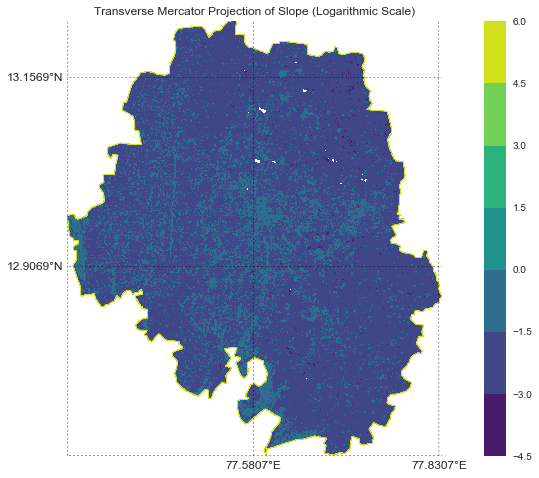

In [16]:
# plot the slope magnitude 
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, facecolor='w', frame_on=True)
m = tmercPlot(np.log(mag), geotransform, overridemethod='y')

plt.title("Transverse Mercator Projection of Slope (Logarithmic Scale)")
cbar = plt.colorbar()

plt.show()

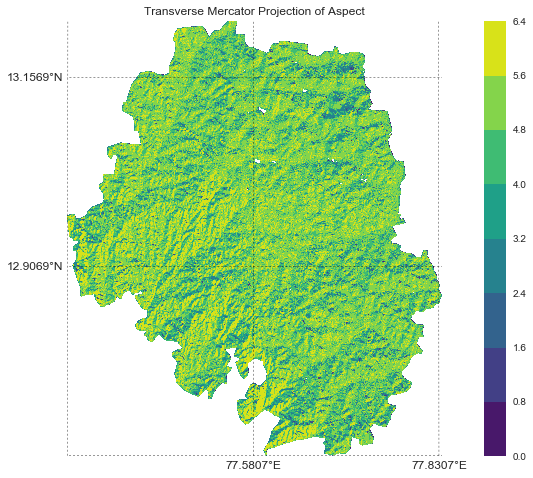

In [17]:
# plot the slope aspect 
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, facecolor='w', frame_on=True)
m = tmercPlot(aspect, geotransform, overridemethod='y')

plt.title("Transverse Mercator Projection of Aspect")
cbar = plt.colorbar()

plt.show()

## Hillshade image
A hillshade image is a grayscale 3D representation of the surface, with the sun's relative position taken into account for shading the image. This algorithm uses the altitude and azimuth properties to specify the sun's position. The shadow is usually drawn considering that the sun is at 315 degrees of azimuth and 45 degrees over the horizon, which never happens at the north hemisphere. This values avoid strange perceptions, such as seeing the mountain tops as the bottom of a valley.

In [18]:
# Shaded elevation parameters
# Sun direction
azimuth = 315.0
# Sun angle
altitude = 45.0
# Elevation exagerationexaggeration
z = 1.0
# Resolution
scale = 1.0
# No data value for output
NODATA = -9999

# Needed for numpy conversions
deg2rad = 3.141592653589793 / 180.0
rad2deg = 180.0 / 3.141592653589793

In [19]:
sx, sy = gradient(elevation)

shadedSlope = pi/2. - arctan(sqrt(sx*sx + sy*sy))
shadedAspect = arctan2(-sx, sy)

azimuthrad = azimuth*pi / 180.
altituderad = altitude*pi / 180.

shaded = sin(altituderad) * sin(shadedSlope)\
     + cos(altituderad) * cos(shadedSlope)\
     * cos(azimuthrad - shadedAspect)
        
hillshade = 255*(shaded + 1)/2

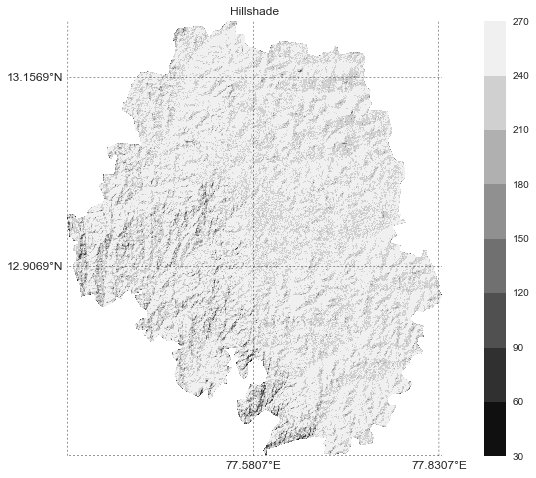

In [20]:
# plot the hillshade
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, facecolor='w', frame_on=True)
m = tmercPlot(hillshade, geotransform, overridemethod='y',cmName='gray')

plt.title("Hillshade")
cbar = plt.colorbar()

plt.show()

## Flood Inundation Model with Flood Fill Algorithm

Flood is an extremely complex catastrophic phenomenon and there are various factors that affects the impact a flooding event will have. Hydrological flood models can be infinitely complex and extremely expensive to develop. Such models are essential for engineering complex flood control systems. However for people like risk / asset managers and first responders such complex models can be an overkill, as they are only interested in the probable impact in an area in case of floods. Flood inundation geospatial models are a powerful tool in estimating / simulating the potential impact of a flood.

Our flood inundation model is an easy-to-comprehend model built using a popular image processing technique, named Flood fill algorithm. Flood fill, also called seed fill, is an algorithm that determines the area connected to a given node in a multi-dimensional array. It is used in the "bucket" fill tool of paint programs to fill connected, similarly-colored areas with a different color, and in games such as Go and Minesweeper for determining which pieces are cleared. When applied on an image to fill a particular bounded area with color, it is also known as boundary fill.

This simple first-order model starts with a single point (usually a known water body) and floods an area with the maximum volume of water that a flood basin can hold at a particular flood stage. Usually this analysis is worst-case
scenario. The algorithm is modified to run on an array created from the digital elevation model, and masked based on the starting point. The queue can also be implemented as eight-ways priority queue for faster fill.  The queue based approach eliminates the need of recursively navigating through the raster image multiple times.

Ref: 
- Learning Geo Spatial Analysis with Python by Joel Lawhead
- https://en.wikipedia.org/wiki/Flood_fill


In [21]:
def floodFill(col,rw,mask):
    """
    Crawls a mask array containing only 1 and 0 values from the
    starting point (col=column, rw=row - a.k.a. x,y) and returns
    an array with all 1 valuesconnected to the starting cell.
    This algorithm performs a 4-way check non-recursively.
    """
    # cells already filled
    filled = set()
    # cells to fill
    fill = set()
    fill.add((col,rw))
    width = mask.shape[1]-1
    height = mask.shape[0]-1
    # Our output inundation array
    flood = np.zeros_like(mask, dtype=np.int8)
    # Loop through and modify the cells which
    # need to be checked.
    while fill:
        # Grab a cell
        x,y = fill.pop()
        if y == height or x == width or x < 0 or y < 0:
            # Don't fill
            continue
        if mask[y][x] == 1:
            # Do fill
            flood[y][x]=1
            filled.add((x,y))
            # Check neighbors for 1 values
            west =(x-1,y)
            east = (x+1,y)
            north = (x,y-1)
            south = (x,y+1)
            if not west in filled:
                fill.add(west)
            if not east in filled:
                fill.add(east)
            if not north in filled:
                fill.add(north)
            if not south in filled:
                fill.add(south)
            
    return flood

In [22]:
# set raster paths
raster = "./images/output/bengaluru_cropped.tif"

# read the raster datasets
dataset, elevation, geotransform = readRaster(raster)

In [23]:
# Set the start or seed point - lon, lat and elevation
sx_lon,sy_lat, start_elev = 77.61670702, 12.90601599 , 850
    # 77.6194536, 12.9819699, 850 #Ulsoor Lake
    # 77.61670702, 12.90601599 , 840 # Madiwala Lake 

# Create a copy for the mask
data = elevation
    
# Create the mask based on starting elevation
flood_data = np.where(data < start_elev * 0.95, 1,0)

# Convert lon and lat to pixel values
sx,sy = latlon2Pixel(geotransform,sx_lon, sy_lat)

# Start the flood fill
print "Beginning flood fill"
fldModel = floodFill(sx,sy, flood_data)
print "Finished Flood fill"

Beginning flood fill
Finished Flood fill


/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


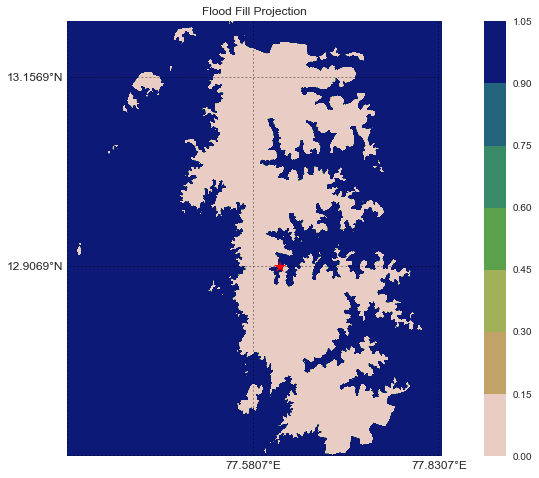

In [24]:
# plot the flood fill 
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, facecolor='w', frame_on=True)
m = tmercPlot(fldModel, geotransform, overridemethod='y',cmName='gist_earth_r')

sxx,syy = m(sx_lon, sy_lat)

m.plot(sxx, syy, marker="*", color='red', markersize=12)

plt.title("Flood Fill Projection")
cbar = plt.colorbar()

plt.show()

## Improved Flood Fill

An inherent issue with the vanilla flood-fill algorithm as above is that the results vary widely depending on the seed point and threshold value. It also doesn’t take into account the relative difference of the neighbouring cell values and the fill is decided always in comparison with the threshold.

We developed a variation of the flood fill algorithm that takes a seed point and then uses the cell value to compare with the neighbouring cells to determine the fill direction. This is apt for a first order flood inundation model as the flow of the water will depend on elevation difference between neigbouring cells.


In [25]:
from linecache import getline
def floodFlow(sx,sy,elevation):
    """
    Crawls through the elevation array
    starting from the seed and fills the
    nearby cells that are lower in depth.
    """
    # cells already filled
    checked = set()
    # cells to fill
    tocheck = set()
    tocheck.add((sx,sy))
    # get width, height and seed value
    width = elevation.shape[1]-1
    height = elevation.shape[0]-1
    seed = elevation[sy][sx]
    
    # Our output inundation array
    #flood = np.ones_like(elevation, dtype=np.int8)
    elevationmask = np.where(elevation > seed ,0,1)
    
    iLoop = 0
    
    # Loop through and modify the cells which
    # need to be checked.
    while tocheck:
        # Grab a cell
        x,y = tocheck.pop()
        
        if y == height or x == width or x < 0 or y < 0:
            # Don't fill
            continue
        
        if elevationmask[y][x]==0:
            checked.add((x,y))
            continue
            
        # Do fill current cell
        #flood[y][x]=0
        
        cellelevation = elevation[y][x]
        
        # Check neighbors
        west, westelevation =(x-1,y), elevation[y][x-1]
        east, eastelevation = (x+1,y), elevation[y][x+1]
        north, northelevation = (x,y-1), elevation[y-1][x]
        south, southelevation = (x,y+1), elevation[y+1][x]
            
        if not west in checked:
            if westelevation > cellelevation:
                elevationmask[y][x-1]=0
                checked.add(west)
            else: tocheck.add(west)
            
        if not east in checked:
            if eastelevation > cellelevation:
                elevationmask[y][x+1]=0
                checked.add(east)
            else: tocheck.add(east)
            
        if not north in checked:
            if northelevation > cellelevation:
                elevationmask[y-1][x]=0
                checked.add(north)
            else: tocheck.add(north)
            
        if not south in checked:
            if southelevation > cellelevation:
                elevationmask[y+1][x]=0
                checked.add(south)
            else: tocheck.add(south)
            
        # add current point to checked    
        checked.add((x,y))
        iLoop+=1
            
    print iLoop
    return elevationmask

In [26]:
sx_lon,sy_lat = 77.61670702, 12.90601599 
# 77.6194536, 12.9819699 #Ulsoor Lake
# 77.61670702, 12.90601599 # Madiwala Lake 

# Create a copy for the mask
flowdata = elevation

#no data count
nodatacount = np.count_nonzero(flowdata == 0)

#change nodata to 9999
flowdata[flowdata == 0] = 9999

# Convert lon and lat to pixel values
sx,sy = latlon2Pixel(geotransform,sx_lon, sy_lat)

# Start the flood fill
print "Beginning flood fill"
fldFlowModel = floodFlow(sx,sy, flowdata)
print "Finished Flood fill"

fill_idx = round(float(np.count_nonzero(fldFlowModel == 1)) / 
                 float((fldFlowModel.shape[1] * fldFlowModel.shape[0]) - nodatacount), 3) 
print fill_idx

Beginning flood fill
170
Finished Flood fill
0.474


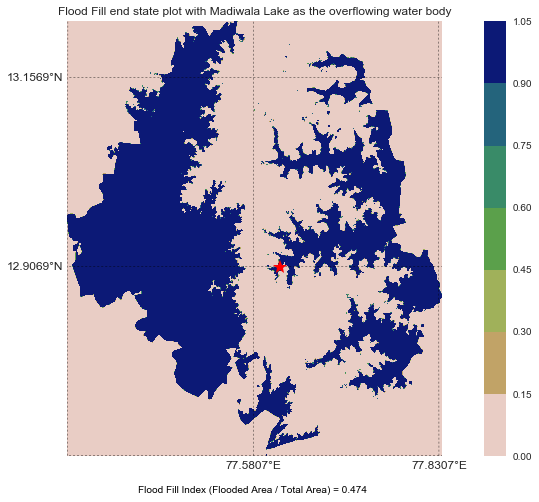

In [27]:
# plot the flood fill 
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, facecolor='w', frame_on=True)
m = tmercPlot(fldFlowModel, geotransform, overridemethod='y',cmName='gist_earth_r')

sxx,syy = m(sx_lon, sy_lat)

m.plot(sxx, syy, marker="*", color='red', markersize=15)

ax.text(0.8, -0.09, 'Flood Fill Index (Flooded Area / Total Area) = '+ str(fill_idx),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='black')

plt.title("Flood Fill end state plot with Madiwala Lake as the overflowing water body")
cbar = plt.colorbar()

plt.show()

## View the output as an animation
The image outputs from the flood fill algorithm can be saved at intermediate stages and be stitched together as a gif to display how the water will propagate through the terrain

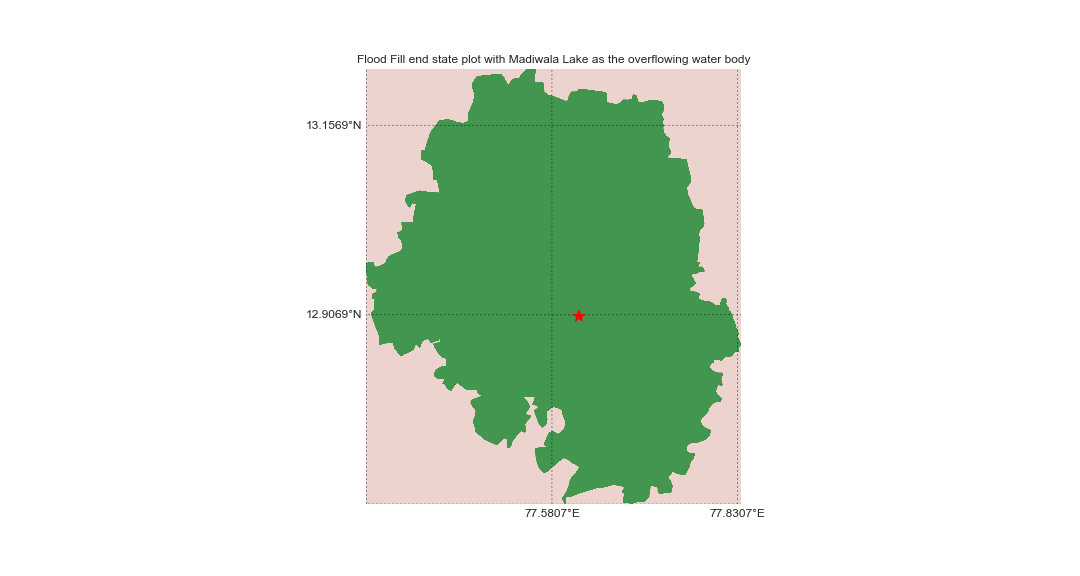

In [1]:
from IPython.display import Image
Image(filename="./images/output/flood_fill_animation.gif")

## k-Means clustering of elevation

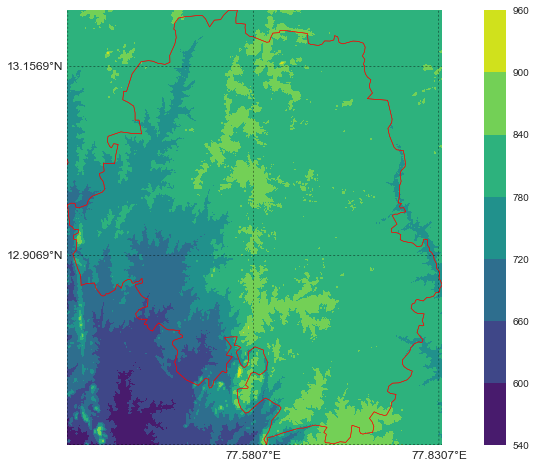

In [28]:
mainRaster = "./images/output/cdnd43rx.tif"
subRaster = "./images/output/bengaluru_cropped.tif"
shpfilePath = "./images/maps-master/Districts/Census_2011"
shpfileName = "2011_Dist"
clipElevation, clipGeoTrans = ClipDEMTileBySubRaster(mainRaster, subRaster, True, shpfilePath, shpfileName)

In [29]:
xres, yres, xmin, ymin, xmax, ymax, x_center, y_center = calculateXY(clipElevation, clipGeoTrans)

In [30]:
# Copy data for clustering
clusterelevation = clipElevation

# Pre-Process data for clustering into a data frame
x = []
y = []
elevation = []

for i in range(np.shape(clusterelevation)[0]):
    for j in range(np.shape(clusterelevation)[1]):
        x.append(xmin + xres * j)
        y.append(ymin + yres * i)
        elevation.append(clusterelevation[i,j])
        
data_height = pd.DataFrame({ 'x' : x, 'y' : y, 'elevation' : elevation})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1268ac610>]], dtype=object)

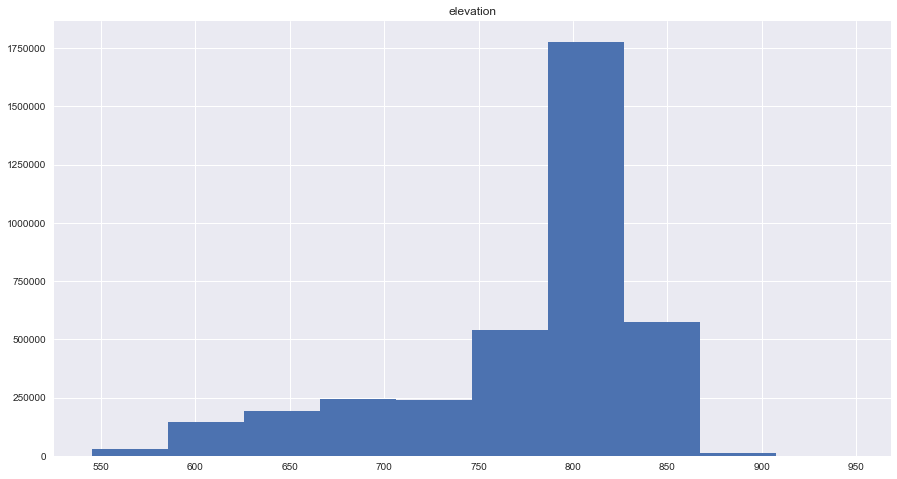

In [31]:
plt.figure(figsize=(15, 8))
data_height.hist(column=['elevation'])

In [32]:
cluster_range = range( 2, 11 )
cluster_errors = []


for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( data_height )
    cluster_errors.append( clusters.inertia_ )

In [33]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

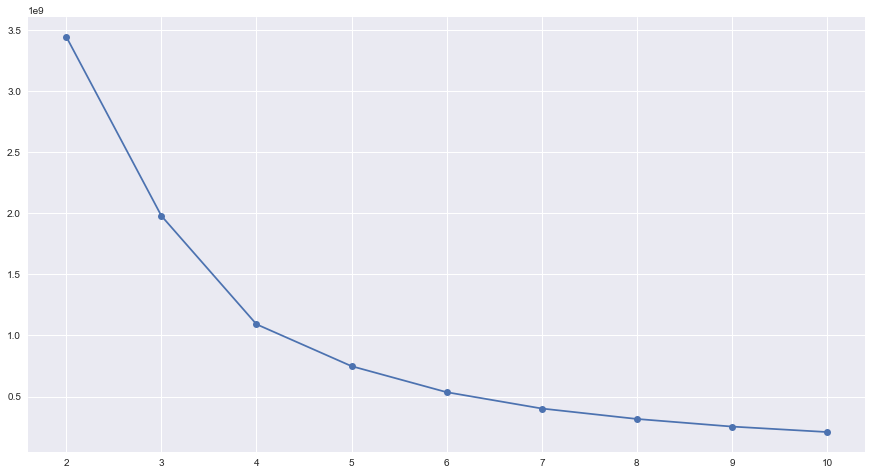

In [34]:
plt.figure(figsize=(15,8))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [35]:
clusters = KMeans(3)  # 3 clusters
clusters.fit( data_height )

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [36]:
unique, counts = np.unique(clusters.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 2716136, 1: 454534, 2: 588703}

In [37]:
data_height["3cluster"] = clusters.labels_
data_height['mean.elevation1'] = \
    data_height['elevation'].groupby(data_height['3cluster']).transform('mean')

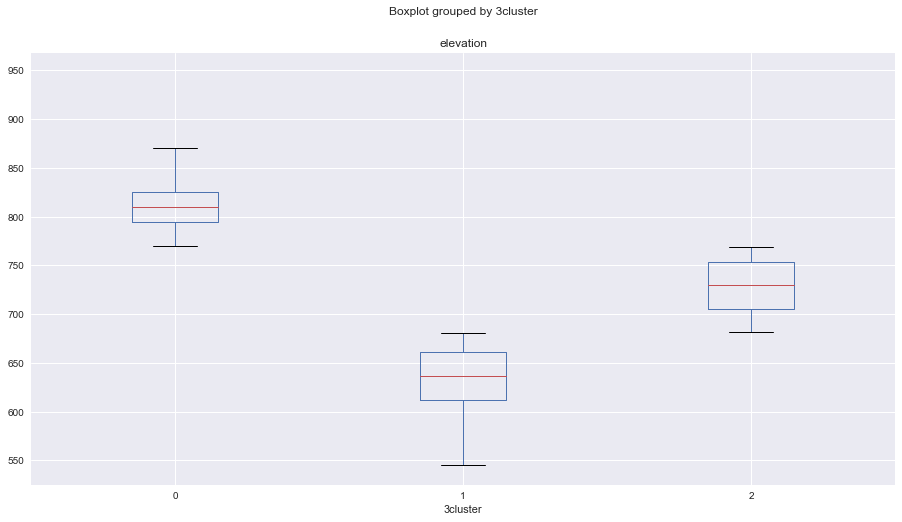

In [38]:
plt.figure(figsize=(15, 8))
data_height.boxplot(by='3cluster', column=['elevation'])

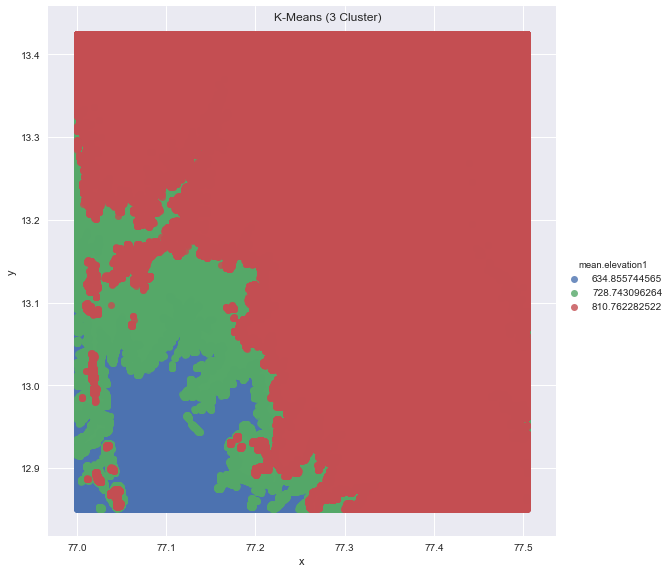

In [39]:
plt.figure(figsize=(15, 8))
sp = sn.lmplot( "x", "y", data=data_height,
            hue = "mean.elevation1",
            fit_reg=False, size = 8)
plt.subplots_adjust(top=0.99)
sp.fig.suptitle('K-Means (3 Cluster)') # can also get the figure from plt.gcf()

In [40]:
clusters = KMeans(4)  # 4 clusters
clusters.fit( data_height[["x", "y","elevation"]]  )

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [41]:
unique, counts = np.unique(clusters.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 1381606, 1: 484591, 2: 365499, 3: 1527677}

In [42]:
data_height["4cluster"] = clusters.labels_
data_height['mean.elevation2'] = \
    data_height['elevation'].groupby(data_height['4cluster']).transform('mean')

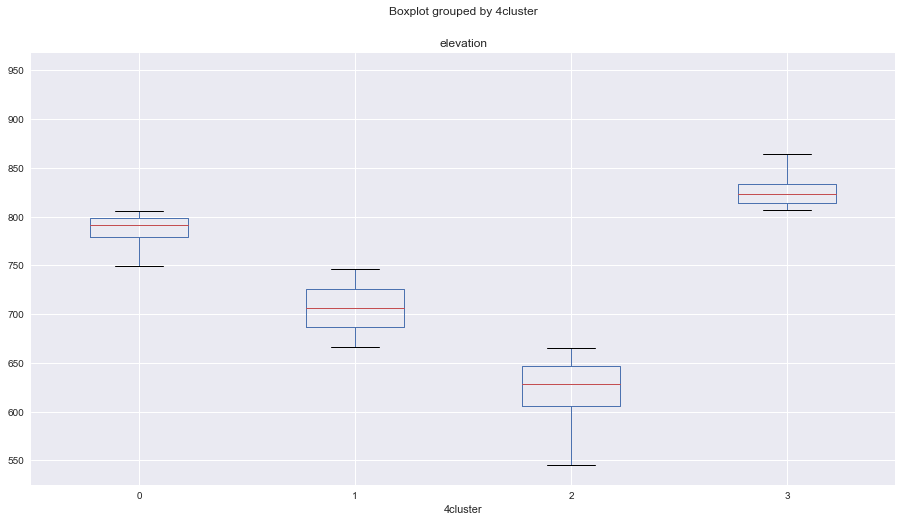

In [43]:
plt.figure(figsize=(15, 8))
data_height.boxplot(by='4cluster', column=['elevation'])

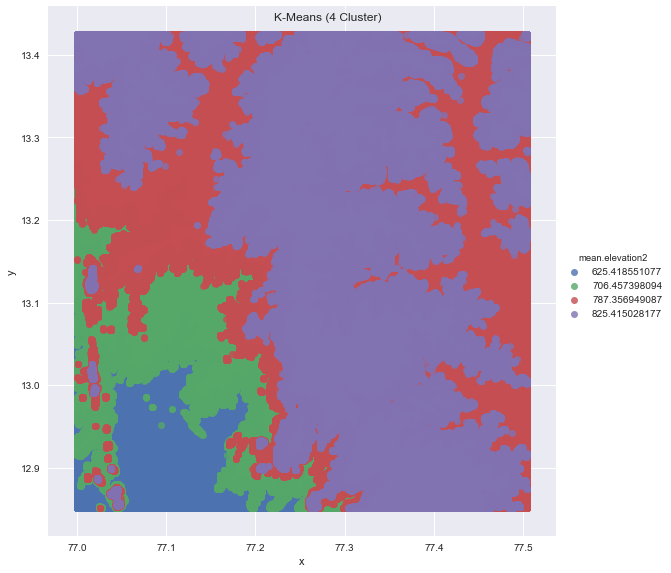

In [44]:
plt.figure(figsize=(15, 8))
sp = sn.lmplot( "x", "y", data=data_height,
            hue = "mean.elevation2",
            fit_reg=False, size = 8 )
plt.subplots_adjust(top=0.99)
sp.fig.suptitle('K-Means (4 Cluster)') # can also get the figure from plt.gcf()